In [1]:
import numpy as np
import pandas as pd
import pybaseball
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
from scipy.special import gammaln
from scipy.optimize import minimize
import statsmodels.api as sm

# Setup

In [3]:
from pybaseball.lahman import batting
from pybaseball.lahman import pitching

# Get the data
batting_data = batting()
pitching_data = pitching()


In [20]:
from pybaseball.lahman import batting
from pybaseball.lahman import pitching

# Get the data
batting_data = batting()
pitching_data = pitching()

# Add player's name
def add_name(ID):
    _player = _players.loc[_players.key_bbref.isin([ID]),:]
    if not _player.empty:
        try:
            fname = _player.name_first.item().capitalize() #if type(_player.name_first.item())==str  else "NaN "
            lname = _player.name_last.item().capitalize() #if type(_player.name_last.item())==str  else "NaN "
            name = fname + ' ' + lname
        except:
            print(_player)

    else:
        name = " "
    return  name

# Get names of players
_players = pybaseball.playerid_reverse_lookup(batting_data.playerID.tolist(),key_type='bbref')
_players.dropna(subset=["name_last","name_first"],axis=0,inplace=True)

# Remove unneeded columns
rows_to_keep = (batting_data.AB>0) & (batting_data.lgID == "NL") & (batting_data.yearID > 1980)
cols_to_keep = ["AB","H","2B","3B","HR","playerID","yearID"]

# There are multiple rows for each player so group by player and get total H and AB, and take mean of years
bd = batting_data.loc[rows_to_keep ,cols_to_keep].groupby(by="playerID",as_index=True).agg({"AB": "sum", "H": "sum", "2B": "sum", "3B": "sum", "HR": "sum", "yearID": "mean"}).reset_index()#.sum().reset_index()
bd.loc[:,"yearID"] = bd.loc[:,"yearID"].astype(int)

# Add singles and non-hits to DF
bd.loc[:,"1B"] = bd.loc[:,'H'] - bd.loc[:,['2B','3B','HR']].sum(axis=1)
bd.loc[:,"Non-hit"] = bd.loc[:,'AB'] - bd.loc[:,'H']

# Add the player's name for ease of reading
bd["Name"] = bd.apply(lambda row: add_name(row.playerID),axis=1)

# Add batting average
bd["Avg"] = bd.H / bd.AB

# Add slugging percentage 
bd.loc[:,"Slg"] = (bd.loc[:,"1B"] + 2*bd.loc[:,"2B"] + 3*bd.loc[:,"3B"] + 4*bd.loc[:,"HR"])/bd.loc[:,"AB"] 

# Is pitcher?
bd.loc[:,"Pitcher"] = bd.playerID.isin(pitching_data.loc[pitching_data.G > 3,"playerID"])

# Change order
bd = bd.loc[:,["playerID","Name","yearID","AB","Non-hit","H","1B","2B","3B","HR","Avg","Slg","Pitcher"]]

# Check out the DF
bd.sample(10)

,playerID,Name,yearID,AB,Non-hit,H,1B,2B,3B,HR,Avg,Slg,Pitcher
1146,davenjo01,Joe Davenport,2001,1,0,1,1,0,0,0,1.000000,1.000000,True
1882,greenan01,Andy Green,2006,230,184,46,36,7,1,2,0.200000,0.265217,False
3748,parrist01,Steve Parris,1997,156,131,25,21,4,0,0,0.160256,0.185897,True
3007,manueje01,Jerry Manuel,1981,60,48,12,3,5,1,3,0.200000,0.466667,False
2586,kimbrcr01,Craig Kimbrel,2015,1,1,0,0,0,0,0,0.000000,0.000000,True
381,benesan01,Andy Benes,1995,741,635,106,77,21,0,8,0.143050,0.203779,True
625,brownke02,Keith Brown,1990,6,6,0,0,0,0,0,0.000000,0.000000,True
3157,mccraro01,Rodney Mccray,1992,1,0,1,1,0,0,0,1.000000,1.000000,False
4260,rodrise01,Sean Rodriguez,2017,931,721,210,131,40,3,36,0.225564,0.390977,False
3884,pettyad01,Adam Pettyjohn,2008,1,1,0,0,0,0,0,0.000000,0.000000,True


## Figure 10.1
Percentages of each players’ hits that are made up of singles, doubles, triples, or home runs.

In [48]:
bd.loc[bd.H>min_atbat,hittype]/bd.loc[bd.H>min_atbat,"AB"]

6       0.030645
9       0.023316
10      0.015066
12      0.037442
13      0.009823
          ...   
5511    0.000000
5512    0.025592
5515    0.022059
5516    0.051724
5517    0.000000
Length: 2423, dtype: float64

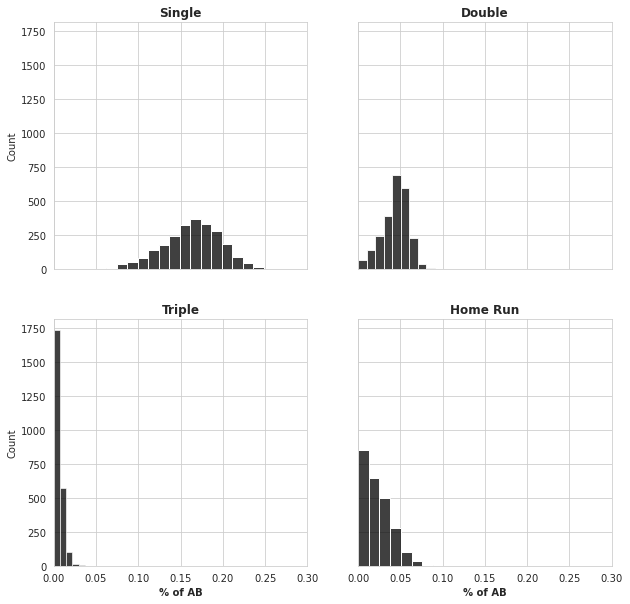

In [44]:
min_atbat=20
with sns.axes_style("whitegrid"):
    # Make figure
    fig, allax = plt.subplots(2,2,sharey=True,sharex=True)
    # flatax = ax.flatten()
    fig.set_size_inches(10,10)

    for cnt,(ax,hittype,name,bins) in enumerate(zip(allax.flatten(),['1B','2B','3B','HR'],["Single","Double","Triple","Home Run"],[20,10,5,10])):
        sns.histplot(bd.loc[bd.H>min_atbat,hittype].count()/bd.loc[bd.H>min_atbat,"AB"],bins=bins,ax=ax,color='k')
        ax.set_xlim(0,0.3)
        ax.set_title(name,fontweight="bold")
        ax.set_xlabel("% of AB",fontweight="bold")
        

Lets check out the leaders in slugging %..

In [50]:
bd.sort_values(by="Slg",ascending=False).head(10)

,playerID,Name,yearID,AB,Non-hit,H,1B,2B,3B,HR,Avg,Slg,Pitcher
877,chacigu01,Gustavo Chacin,2010,1,0,1,0,0,0,1,1.000000,4.000000,True
753,cammaer01,Eric Cammack,2000,1,0,1,0,0,1,0,1.000000,3.000000,True
5444,worrema01,Mark Worrell,2008,2,1,1,0,0,0,1,0.500000,2.000000,True
3448,muntesc01,Scott Munter,2006,1,0,1,0,1,0,0,1.000000,2.000000,True
2942,lyonbr01,Brandon Lyon,2011,1,0,1,0,1,0,0,1.000000,2.000000,True
443,bittije01,Jeff Bittiger,1986,3,2,1,0,0,0,1,0.333333,1.333333,True
3637,olsongr01,Gregg Olson,1996,3,2,1,0,0,0,1,0.333333,1.333333,True
761,campulu01,Luis Campusano,2020,3,2,1,0,0,0,1,0.333333,1.333333,False
3120,maxweja01,Jason Maxwell,1998,3,2,1,0,0,0,1,0.333333,1.333333,False
3167,mcdonke01,Keith Mcdonald,2000,9,6,3,0,0,0,3,0.333333,1.333333,False


## 10.2 The Dirichlet-multinomial distribution


### 10.2.1 Multinomial distribution

In [74]:
experiment = np.random.multinomial(100, 5*[0.2],(1,3))
pd.DataFrame({"1":experiment[0][0],"2":experiment[0][1],"3":experiment[0][2]})

,1,2,3
0,20,22,21
1,25,17,18
2,22,15,18
3,18,19,21
4,15,27,22


Lets do it again with different probabilities:

In [75]:
experiment = np.random.multinomial(100, [.05, .05, .2, .2, .5],(1,3))
pd.DataFrame({"1":experiment[0][0],"2":experiment[0][1],"3":experiment[0][2]})

,1,2,3
0,4,3,5
1,7,5,6
2,14,18,18
3,25,25,23
4,50,49,48


### 10.2.2 Dirichlet distribution


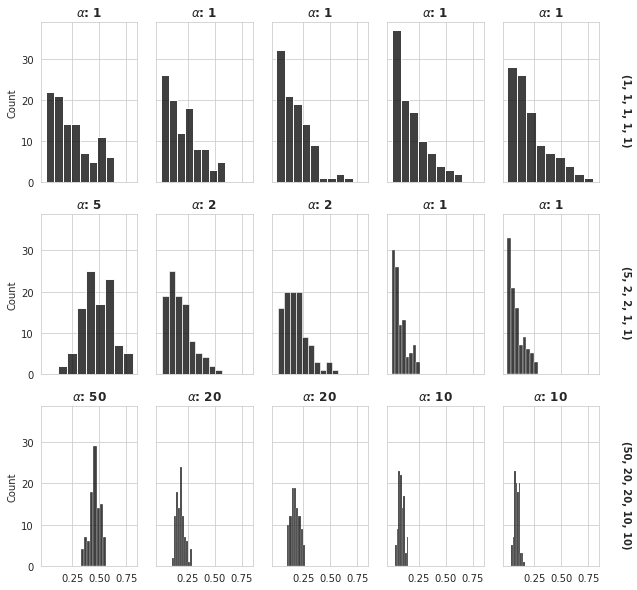

In [134]:
with sns.axes_style("whitegrid"):
    # Make figure
    fig, ax = plt.subplots(3,5,sharey=True,sharex=True)
    # flatax = ax.flatten()
    fig.set_size_inches(10,10)
    
    alphas = [(1, 1, 1, 1, 1),(5, 2, 2, 1, 1),(50, 20, 20, 10, 10)]
    
    for ii,alpha in enumerate(alphas):
        experiment = np.random.dirichlet(alpha,(1,100))#_000_000))
        for jj in range(allax.shape[1]):
                sns.histplot(experiment[0][:,jj],ax=ax[ii,jj],color='k')
                ax[ii,jj].set_xticks([.25,.5,0.75])
                ax[ii,jj].set_title(r"$\alpha$: {}".format(alpha[jj]),fontweight="bold")

        ax[ii,jj].text(x=1.05,y=17.5,s="{}".format(alpha),va="center",rotation=-90,fontweight="bold")
        
        experiment[0][:,0] # <-- access first column
# pd.DataFrame({"1":experiment[0][0],"2":experiment[0][1],"3":experiment[0][2]})

### 10.2.3 Fitting a Dirichlet-multinomial distribution

There is no built-in way to fit a Dirichlet-multinomial in python. Instead I will use this iterative approach to estimate the parameters from a researcher at Microsoft ([paper](https://tminka.github.io/papers/dirichlet/minka-dirichlet.pdf)).

In [276]:
from scipy.special import digamma

# def estimate_alphas_DirichletMultinomial(data,): 

# Get data
data = bd.loc[:,['1B','2B','3B','HR','Non-hit']].to_numpy()

# Get k --> number of counts
k = data.shape[1]
N = data.sum(1)

# Initialize alpha
alpha     = [35,8,1.8,2.8,138]#50*np.ones((1,k))[0]#
alpha_new = np.ones_like(alpha)

# Define criterion for convergence
min_difference = 10**-10
alpha_diff     = 1
# While convergence is not achieved
cnt = 0
while (alpha_diff > min_difference):
    # Sum across alphas
    alpha_sum = np.sum(alpha)
    denom = np.sum(digamma(N + alpha_sum) - digamma(alpha_sum))
    for kk in range(k):
        # Get numerator
        numer = np.sum(digamma(data[:,kk]+alpha[kk]) - digamma(alpha[kk]))
        # Compute new alphas
        alpha_new[kk] = alpha[kk]*(numer/denom)
    print(alpha_diff )
    # Compute difference
    alpha_diff = np.sum(np.abs(alpha_new-alpha))
    alpha_old = alpha
    alpha = alpha_new
    cnt+=1

# print(cnt,alpha,alpha_old)
        


1
161.86593161195282


### Figure 10.3
The density of the Dirichlet distribution compared to the histogram of percentages for each type of hit.

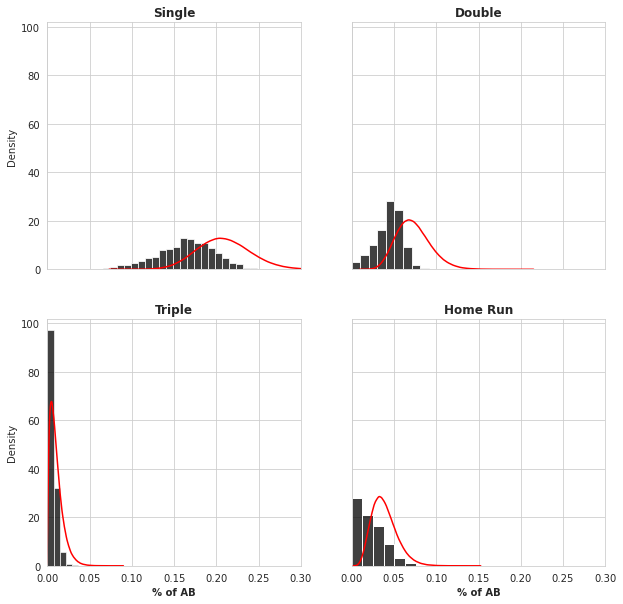

In [277]:
# Minimum number of at bats
min_atbat=20

# Sample from dirichlet using alphas
rvs = pd.DataFrame(stats.dirichlet.rvs(alpha = alpha, size = 1_000_000),columns=['1B','2B','3B','HR','Non-hits'])#[35,8,1.8,2.8,138]

with sns.axes_style("whitegrid"):
    # Make figure
    fig, allax = plt.subplots(2,2,sharey=True,sharex=True)
    fig.set_size_inches(10,10)
    for cnt,(ax,hittype,name,bins) in enumerate(zip(allax.flatten(),['1B','2B','3B','HR'],["Single","Double","Triple","Home Run"],[30,10,5,10])):
        sns.histplot(bd.loc[bd.H>min_atbat,hittype]/bd.loc[bd.H>min_atbat,"AB"],bins=bins,ax=ax,color='k',stat="density")
        sns.kdeplot(rvs.loc[:,hittype],color='r',ax=ax)
        ax.set_xlim(0,0.3)
        ax.set_title(name,fontweight="bold")
        ax.set_xlabel("% of AB",fontweight="bold")
        

In [284]:
true_conc = 6.0
true_frac = np.array([0.45, 0.30, 0.15, 0.09, 0.01])
k = len(true_frac)  # Number of different tree species observed
n = 10  # Number of forests observed
total_count = 50

true_p = stats.dirichlet(true_conc * true_frac).rvs(size=n)
observed_counts = np.vstack([stats.multinomial(n=total_count, p=p_i).rvs() for p_i in true_p])

observed_counts

array([[30, 12,  0,  8,  0],
       [39,  9,  0,  2,  0],
       [36, 13,  1,  0,  0],
       [ 7, 26,  4, 13,  0],
       [23, 21,  1,  4,  1],
       [22, 15, 13,  0,  0],
       [25, 17,  4,  4,  0],
       [23, 19,  8,  0,  0],
       [16, 16, 17,  1,  0],
       [35, 10,  0,  5,  0]])

In [297]:
true_p

array([[6.61769050e-01, 2.48029796e-01, 1.15233649e-04, 9.00859204e-02,
        3.07279458e-27],
       [8.00405487e-01, 1.31764256e-01, 6.54360144e-03, 5.32243248e-02,
        8.06232999e-03],
       [6.75821345e-01, 2.71091416e-01, 5.07935326e-02, 2.24541600e-03,
        4.82912729e-05],
       [1.00653986e-01, 5.74940613e-01, 5.48926247e-02, 2.69512775e-01,
        7.95498795e-10],
       [5.59340794e-01, 2.98319834e-01, 4.06116897e-02, 6.38361086e-02,
        3.78915739e-02],
       [2.51370603e-01, 5.32060608e-01, 2.11662293e-01, 4.90357522e-03,
        2.92100820e-06],
       [4.87651430e-01, 3.31291970e-01, 1.25897955e-01, 5.51586449e-02,
        3.74809379e-13],
       [4.25610144e-01, 3.64471378e-01, 1.60443174e-01, 6.58715580e-03,
        4.28881488e-02],
       [2.81845202e-01, 3.82746284e-01, 3.05554772e-01, 2.81958189e-02,
        1.65792333e-03],
       [5.77220608e-01, 3.60568463e-01, 1.37889206e-03, 6.08320373e-02,
        1.78407759e-15]])

In [301]:
data.sum(1)

array([  3,   5,   3, ..., 136, 174, 221])

In [322]:
import pymc as pm
import arviz as az

# this is a reparamerization of the Dirichlet-Multinomial
with pm.Model() as model:
    frac = pm.Dirichlet("frac", a=np.ones(k))
    conc = pm.Lognormal("conc", mu=1, sigma=1)
    counts = pm.DirichletMultinomial("counts", a=frac*conc,n=data.sum(1),shape=data.shape, observed=data)
    trace = pm.sample(10_000, chains=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac, conc]


array([[<AxesSubplot:title={'center':'frac'}>,
        <AxesSubplot:title={'center':'frac'}>],
       [<AxesSubplot:title={'center':'conc'}>,
        <AxesSubplot:title={'center':'conc'}>]], dtype=object)

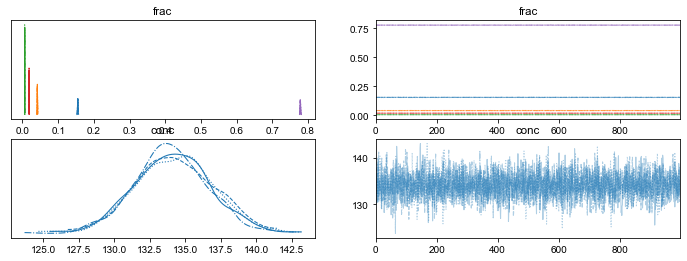

In [306]:
az.plot_trace(data=trace, var_names=["frac", "conc"])

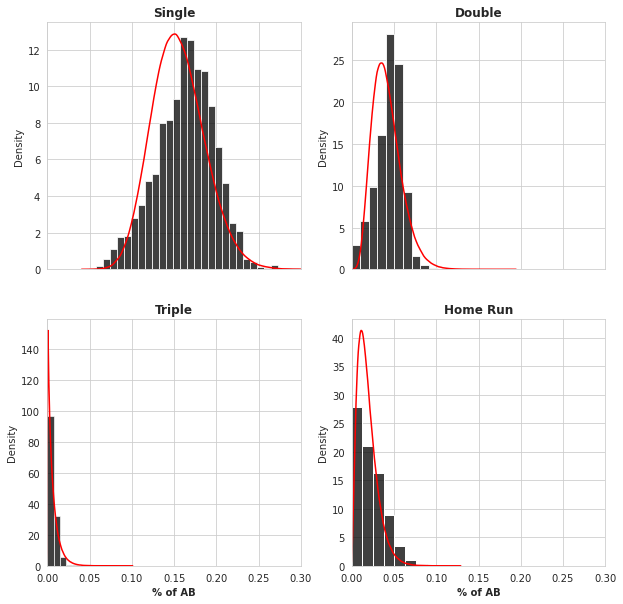

In [321]:
alpha = trace["posterior"]["frac"].mean(("chain","draw")).to_numpy() * trace["posterior"]["conc"].mean(("chain","draw")).to_numpy()

# Minimum number of at bats
min_atbat=20

# Sample from dirichlet using alphas
rvs = pd.DataFrame(stats.dirichlet.rvs(alpha = alpha, size = 1_000_000),columns=['1B','2B','3B','HR','Non-hits'])#[35,8,1.8,2.8,138]

with sns.axes_style("whitegrid"):
    # Make figure
    fig, allax = plt.subplots(2,2,sharey=False,sharex=True)
    fig.set_size_inches(10,10)
    for cnt,(ax,hittype,name,bins) in enumerate(zip(allax.flatten(),['1B','2B','3B','HR'],["Single","Double","Triple","Home Run"],[30,10,5,10])):
        sns.histplot(bd.loc[bd.H>min_atbat,hittype]/bd.loc[bd.H>min_atbat,"AB"],bins=bins,ax=ax,color='k',stat="density")
        sns.kdeplot(rvs.loc[:,hittype],color='r',ax=ax)
        ax.set_xlim(0,0.3)
        ax.set_title(name,fontweight="bold")
        ax.set_xlabel("% of AB",fontweight="bold")
